## Who is the real Winner? - Python Assignment CS253


This is my solution for the Python Assignment of the course CS253 during spring 2024. The task was to predict the Education Level of the Winners of the State Elections, using a dataset of the recent State and UT election winners across India for different states and UTs. ~ A Multi-Class Classification Problem

### Importing Necessary Libraries

- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` for data visualization
- `seaborn` for data visualization
- `sklearn` for machine learning models, tools and evaluation metrics

In [2337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

### Reading CSV

- `train_given` is the training dataset provided
- `test` is the dataset provided for which we have to predict the Education Level
- `deep` is the dataset synthesized using a CTGAN model to increase the training data

In [2338]:
train_given = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
deep = pd.read_csv('deep_data_synthesised.csv')

### Data Description


In [2339]:
print("Shape of Training Dataset given: ", train_given.shape)
print("Shape of Test Dataset: ", test.shape)
print("Shape of Synthesised Dataset: ", deep.shape)

Shape of Training Dataset given:  (2059, 9)
Shape of Test Dataset:  (1374, 8)
Shape of Synthesised Dataset:  (2000, 10)


In [2340]:
train_given.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass


In [2341]:
test.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state
0,0,Geeta Bharat Jain,MEERA BHAYANDAR,IND,2,70 Crore+,11 Crore+,MAHARASHTRA
1,1,Becharam Manna,SINGUR,AITC,1,2 Crore+,13 Lac+,WEST BENGAL
2,2,Sunil Vijay Tingre,VADGAON SHERI,NCP,3,49 Crore+,1 Crore+,MAHARASHTRA
3,3,Asit Mazumder (Tapan),CHUNCHURA,AITC,1,2 Crore+,0,WEST BENGAL
4,4,Hriday Narayan Singh Patel,SAGRI,SP,0,16 Crore+,2 Crore+,UTTAR PRADESH


In Deep Dataset, features passed to model as input are only synthesised along with the target variable. \
The target variable is the `Education`. \
The features are:
- `Party` 
- `Number` of Criminal Cases
- `Total Assets` (Converted to Numerical form as opposed to string in the original dataset)
- `Liabilities` (Converted to Numerical form as opposed to string in the original dataset)
- `State`
- `SC` (If constituency is a Scheduled Castes seat) (`0` for No / `1` for Yes) 
- `ST` (If constituency is a Scheduled Tribes seat) (`0` for No / `1` for Yes) 
- `Doctor` (Candidate has Dr. Title) (`0` for No / `1` for Yes) 
- `Advocate` (Candidate has Adv. Title) (`0` for No / `1` for Yes) 

In [2342]:
deep.head()

,Party,Criminal Case,Total Assets,Liabilities,state,Education,SC,ST,Doctor,Advocate
0,INC,4,150000000,100000000,MAHARASHTRA,Graduate Professional,0,0,0,0
1,BJP,1,2100000,100000000,KARNATAKA,10th Pass,0,0,0,0
2,BJP,1,60000000,70000000,HARYANA,Graduate,0,0,0,0
3,BJP,1,100000000,10000000,KARNATAKA,8th Pass,0,0,0,0
4,BJP,0,10000000,1100000,UTTARAKHAND,Others,0,0,0,0


### Data Preprocessing Part I - Handling Training and Test Data

Converting the `Total Assets` and `Liabilities` to numerical form by removing the Words {`Crore`, `Lac`, `Thou`, `Hund`} and converting them to their respective numerical values.

In [2343]:
def string_to_number(x):
    if isinstance(x, str):
        numeric_part = int(''.join(filter(str.isdigit, x)))
        if 'Crore' in x:
            return numeric_part * 10000000
        elif 'Lac' in x:
            return numeric_part * 100000
        elif 'Thou' in x:
            return numeric_part * 1000
        elif 'Hund' in x:
            return numeric_part * 100
        else:
            return numeric_part
    else:
        return x

In [2344]:
train_given['Total Assets'] = train_given['Total Assets'].apply(string_to_number)
train_given['Liabilities'] = train_given['Liabilities'].apply(string_to_number)
test['Total Assets'] = test['Total Assets'].apply(string_to_number)
test['Liabilities'] = test['Liabilities'].apply(string_to_number)

Taking out useful information from the `Constituency ∇` column by searching for `SC` and `ST`.\
Creating new columns `SC` and `ST` based on the information extracted.

In [2345]:
train_given['SC'] = train_given['Constituency ∇'].str.contains('SC')
train_given['ST'] = train_given['Constituency ∇'].str.contains('ST')
test['SC'] = test['Constituency ∇'].str.contains('SC')
test['ST'] = test['Constituency ∇'].str.contains('ST')

Taking out useful information from the `Candidate` column by searching for `Dr.` and `Adv.`\
Creating new columns `Doctor` and `Advocate` based on the information extracted.

In [2346]:
def Doctor_Check(x):
    return 'Dr.' in x
def Advocate_Check(x):
    return 'Adv.' in x
train_given['Doctor'] = train_given['Candidate'].apply(Doctor_Check)
train_given['Advocate'] = train_given['Candidate'].apply(Advocate_Check)
test['Doctor'] = test['Candidate'].apply(Doctor_Check)
test['Advocate'] = test['Candidate'].apply(Advocate_Check)

### Data Visualization

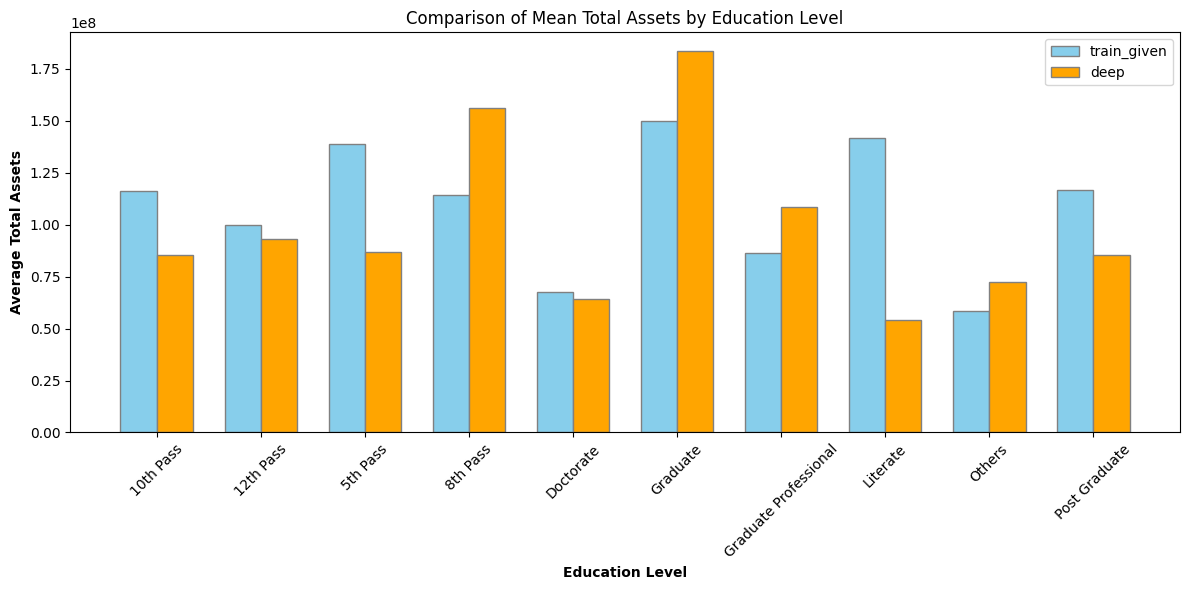

In [2347]:
average_assets1 = train_given.groupby('Education')['Total Assets'].mean().reset_index()
average_assets2 = deep.groupby('Education')['Total Assets'].mean().reset_index()
bar_width = 0.35
x = np.arange(len(average_assets1))
plt.figure(figsize=(12, 6))
plt.bar(x, average_assets1['Total Assets'], color='skyblue', width=bar_width, edgecolor='grey', label='train_given')
plt.bar(x + bar_width, average_assets2['Total Assets'], color='orange', width=bar_width, edgecolor='grey', label='deep')
plt.xlabel('Education Level', fontweight='bold')
plt.ylabel('Average Total Assets', fontweight='bold')
plt.xticks(x + bar_width/2, average_assets1['Education'], rotation=45)
plt.title('Comparison of Mean Total Assets by Education Level')
plt.legend()
plt.tight_layout()
plt.show()

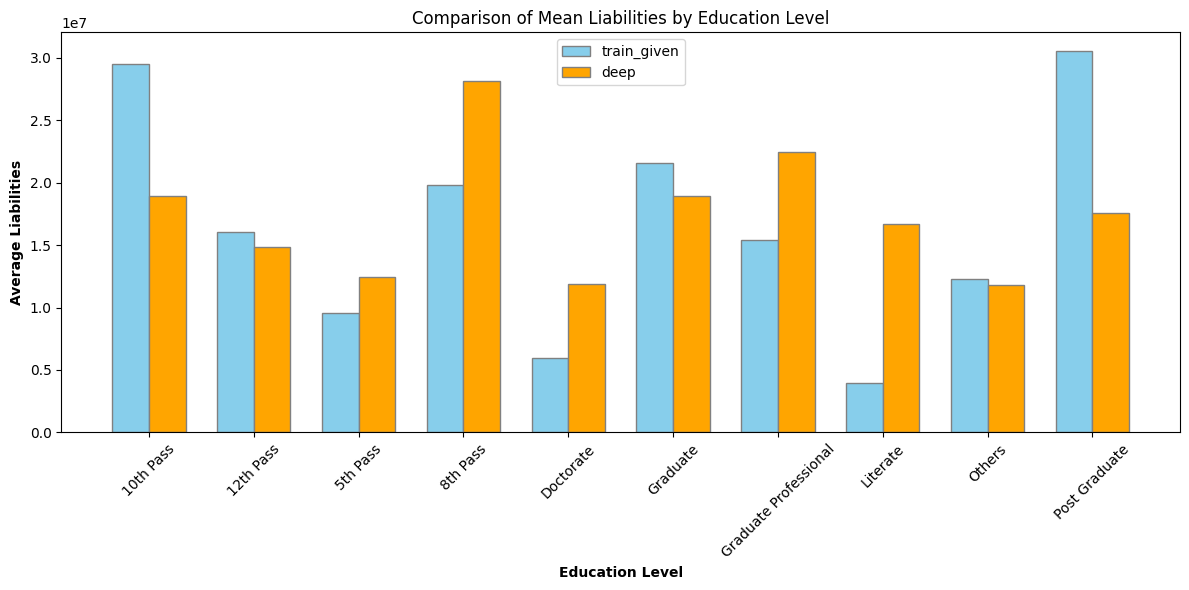

In [2348]:
average_liabilities1 = train_given.groupby('Education')['Liabilities'].mean().reset_index()
average_liabilities2 = deep.groupby('Education')['Liabilities'].mean().reset_index()
bar_width = 0.35
x = np.arange(len(average_liabilities1))
plt.figure(figsize=(12, 6))
plt.bar(x, average_liabilities1['Liabilities'], color='skyblue', width=bar_width, edgecolor='grey', label='train_given')
plt.bar(x + bar_width, average_liabilities2['Liabilities'], color='orange', width=bar_width, edgecolor='grey', label='deep')
plt.xlabel('Education Level', fontweight='bold')
plt.ylabel('Average Liabilities', fontweight='bold')
plt.xticks(x + bar_width/2, average_liabilities1['Education'], rotation=45)
plt.title('Comparison of Mean Liabilities by Education Level')
plt.legend()
plt.tight_layout()
plt.show()

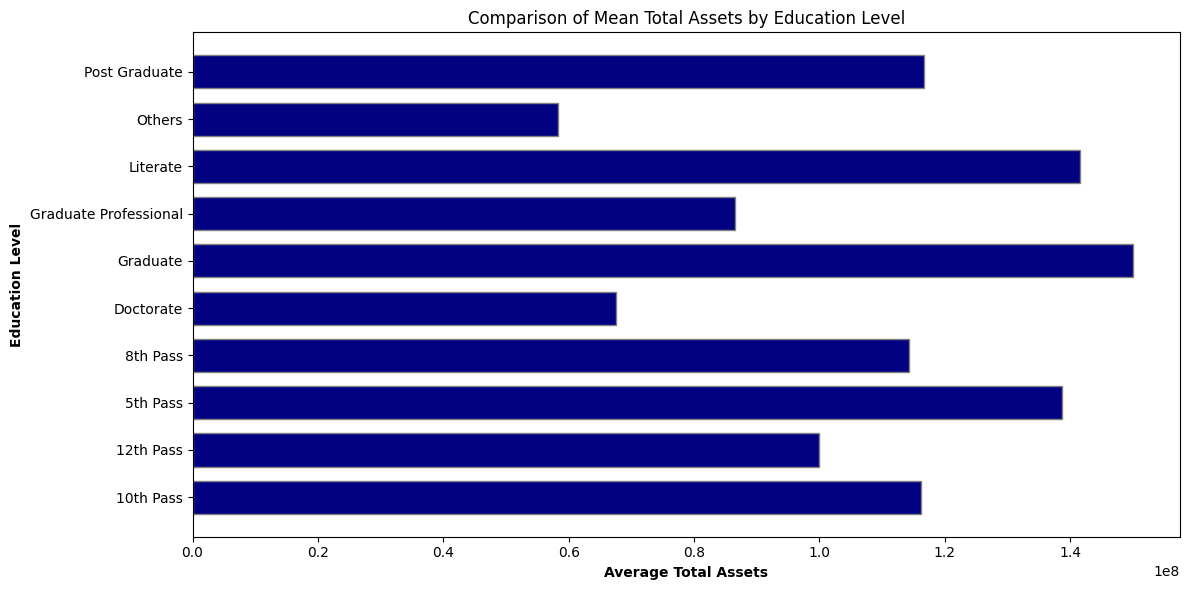

In [2349]:
average_assets1 = train_given.groupby('Education')['Total Assets'].mean().reset_index()
bar_height = 0.7  
y = np.arange(len(average_assets1))  
plt.figure(figsize=(12, 6))
plt.barh(y, average_assets1['Total Assets'], color='navy', height=bar_height, edgecolor='grey', label='train_given') 
plt.ylabel('Education Level', fontweight='bold')  
plt.xlabel('Average Total Assets', fontweight='bold')  
plt.yticks(y, average_assets1['Education']) 
plt.title('Comparison of Mean Total Assets by Education Level')
plt.tight_layout()
plt.show()

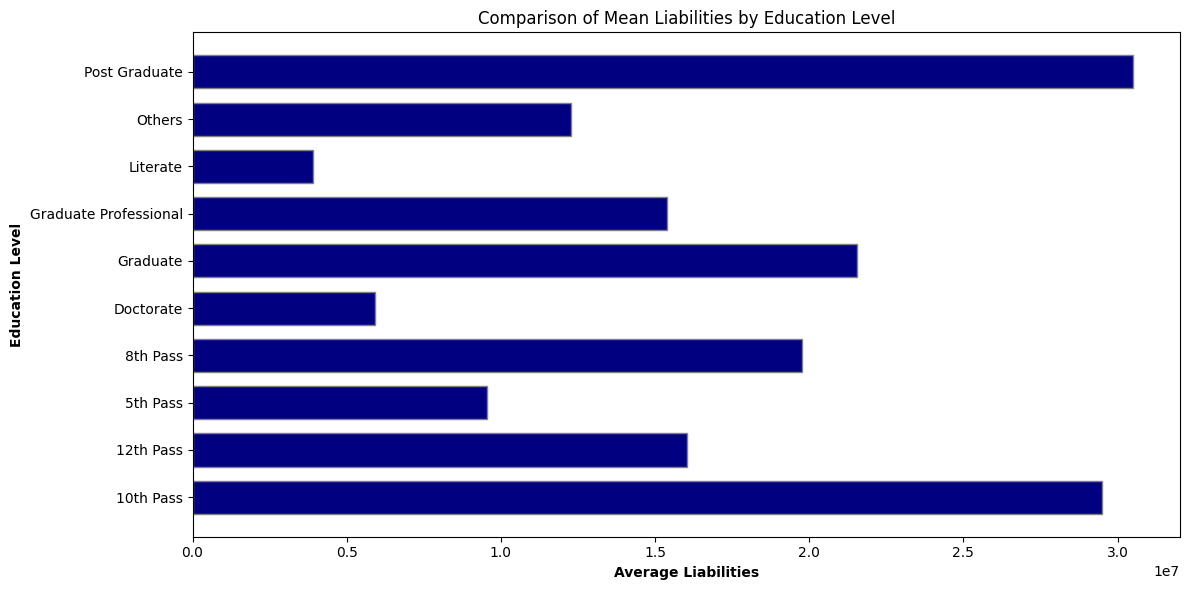

In [2350]:
average_assets1 = train_given.groupby('Education')['Liabilities'].mean().reset_index()
bar_height = 0.7  
y = np.arange(len(average_assets1))  
plt.figure(figsize=(12, 6))
plt.barh(y, average_assets1['Liabilities'], color='navy', height=bar_height, edgecolor='grey', label='train_given') 
plt.ylabel('Education Level', fontweight='bold')  
plt.xlabel('Average Liabilities', fontweight='bold')  
plt.yticks(y, average_assets1['Education']) 
plt.title('Comparison of Mean Liabilities by Education Level')
plt.tight_layout()
plt.show()

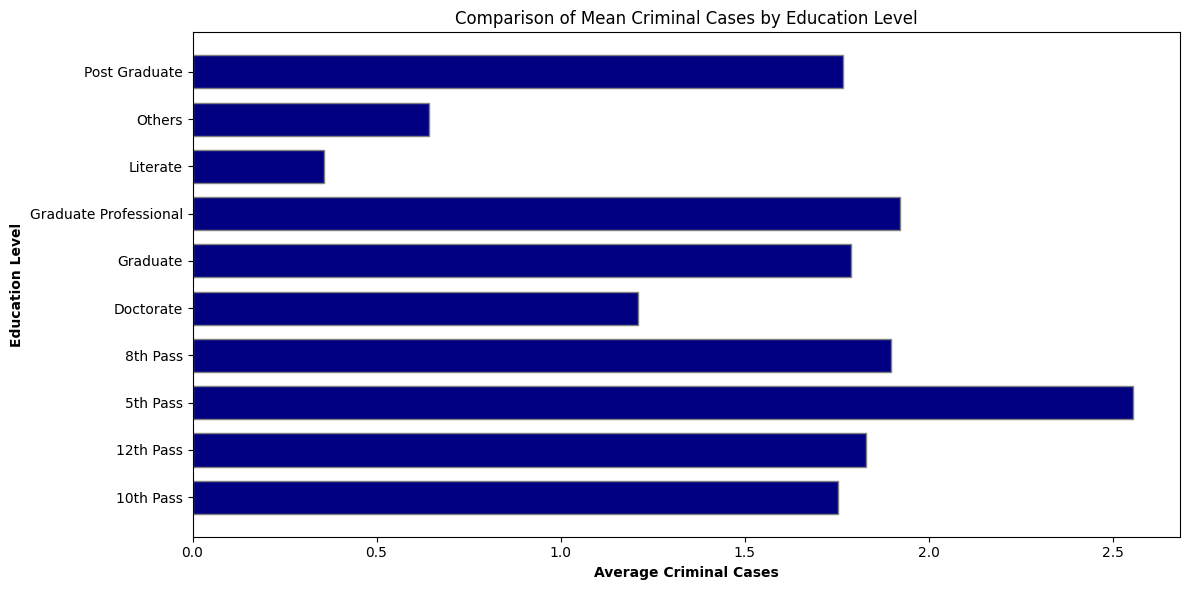

In [2351]:
average_assets1 = train_given.groupby('Education')['Criminal Case'].mean().reset_index()
bar_height = 0.7  
y = np.arange(len(average_assets1))  
plt.figure(figsize=(12, 6))
plt.barh(y, average_assets1['Criminal Case'], color='navy', height=bar_height, edgecolor='grey', label='train_given') 
plt.ylabel('Education Level', fontweight='bold')  
plt.xlabel('Average Criminal Cases', fontweight='bold')  
plt.yticks(y, average_assets1['Education']) 
plt.title('Comparison of Mean Criminal Cases by Education Level')
plt.tight_layout()
plt.show()

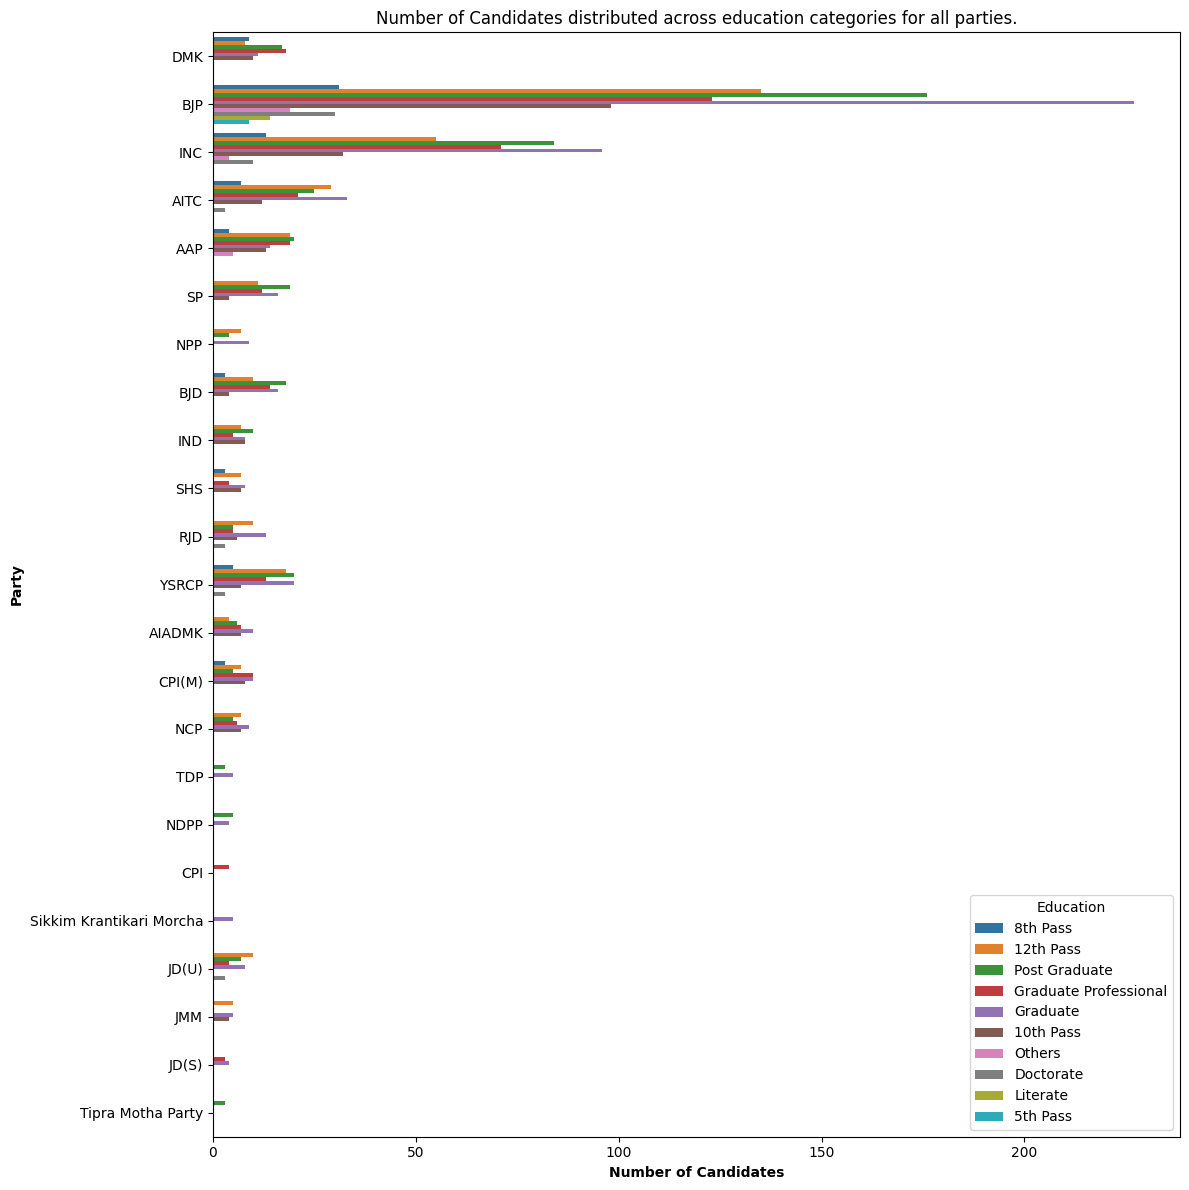

In [2352]:
plt.figure(figsize=(12, 12))
sns.countplot(y='Party', hue='Education', data=train_given)
plt.xlabel('Number of Candidates', fontweight='bold')
plt.ylabel('Party', fontweight='bold')
plt.title('Number of Candidates distributed across education categories for all parties.')
plt.legend(title='Education')
plt.tight_layout()
plt.show()

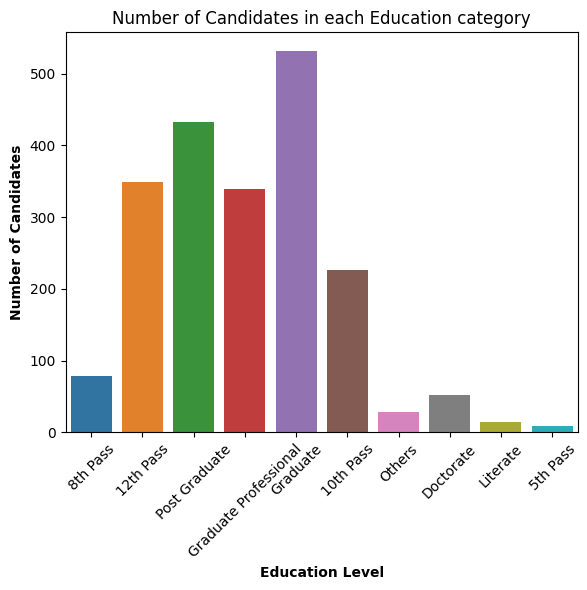

In [2353]:
plt.figure(figsize=(6, 6))
sns.countplot(x='Education', data=train_given)
plt.xlabel('Education Level', fontweight='bold')
plt.ylabel('Number of Candidates', fontweight='bold')
plt.title('Number of Candidates in each Education category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

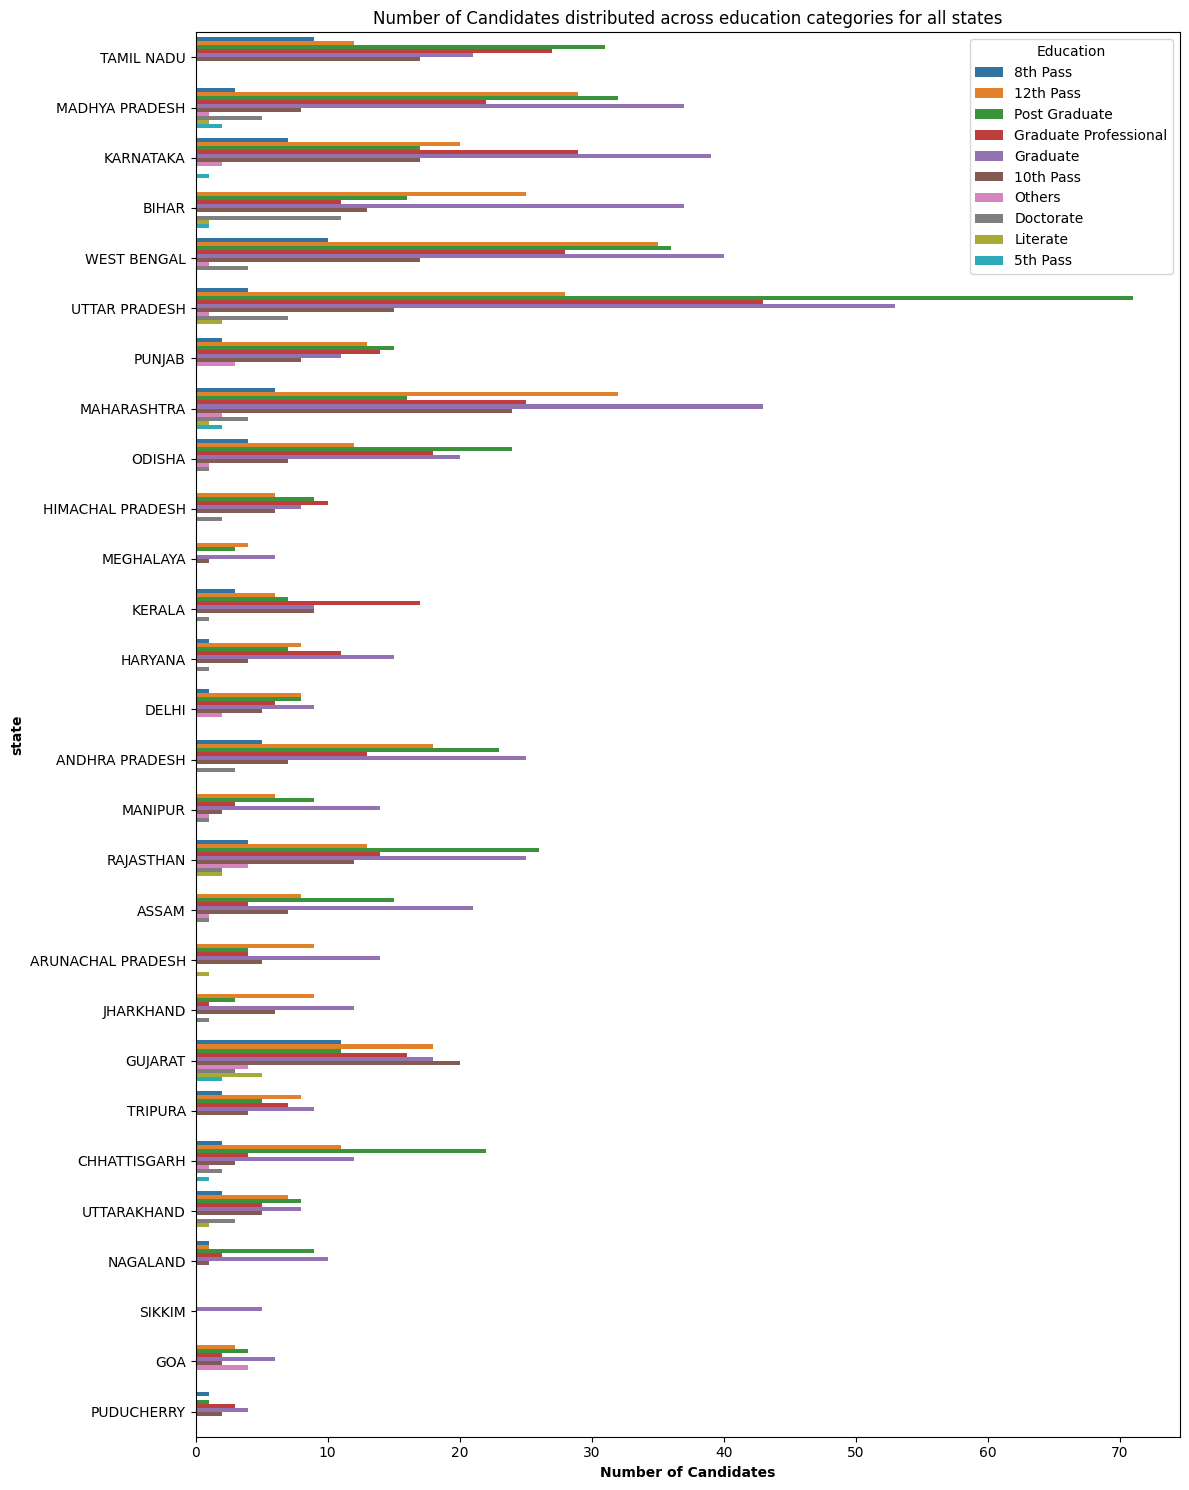

In [2354]:
plt.figure(figsize=(12, 15))
sns.countplot(y='state', hue='Education', data=train_given)
plt.xlabel('Number of Candidates', fontweight='bold')
plt.ylabel('state', fontweight='bold')
plt.title('Number of Candidates distributed across education categories for all states')
plt.legend(title='Education')
plt.tight_layout()
plt.show()

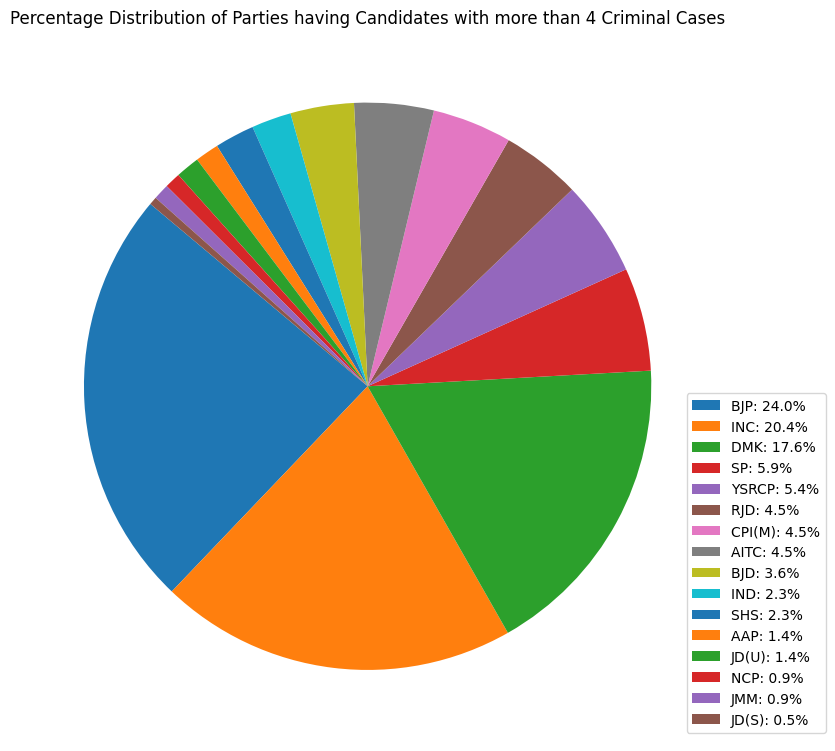

In [2355]:
filtered_df = train_given[train_given['Criminal Case'] > 4]
total_candidates = filtered_df.shape[0]
party_counts = filtered_df['Party'].value_counts()
percentage_distribution = (party_counts / total_candidates) * 100

plt.figure(figsize=(8, 8))
patches, _ = plt.pie(percentage_distribution, startangle=140, pctdistance=0.85)
plt.title('Percentage Distribution of Parties having Candidates with more than 4 Criminal Cases')
plt.axis('equal')
legend_labels = [f'{party}: {percentage:.1f}%' for party, percentage in zip(party_counts.index, percentage_distribution)]
plt.legend(legend_labels, loc="upper left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

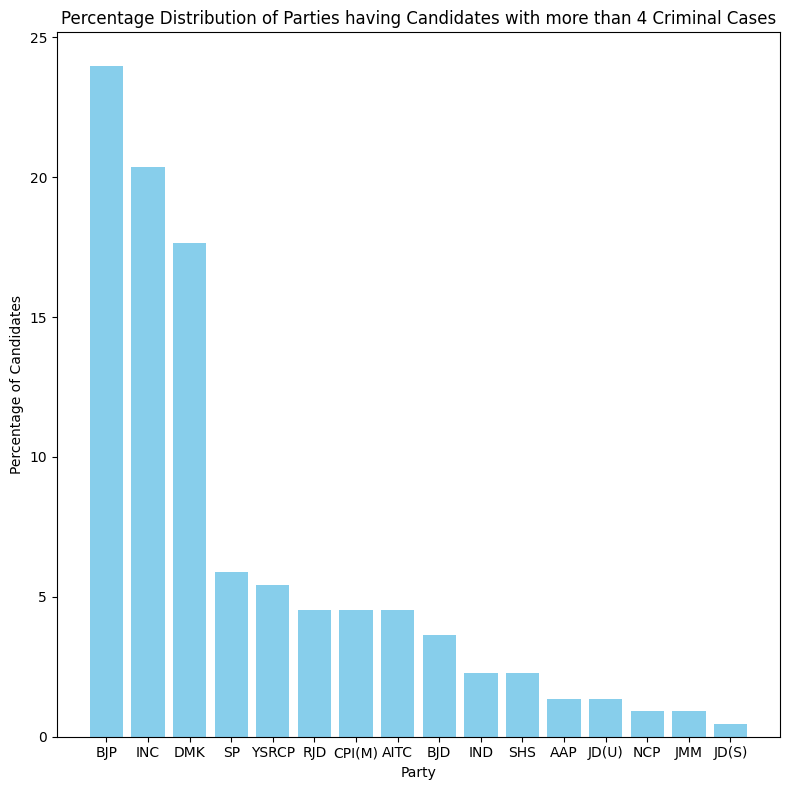

In [2356]:
filtered_df = train_given[train_given['Criminal Case'] > 4]
total_candidates = filtered_df.shape[0]
party_counts = filtered_df['Party'].value_counts()
percentage_distribution = (party_counts / total_candidates) * 100

plt.figure(figsize=(8, 8))
plt.bar(percentage_distribution.index, percentage_distribution, color='skyblue')
plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage Distribution of Parties having Candidates with more than 4 Criminal Cases')
plt.tight_layout()
plt.show()

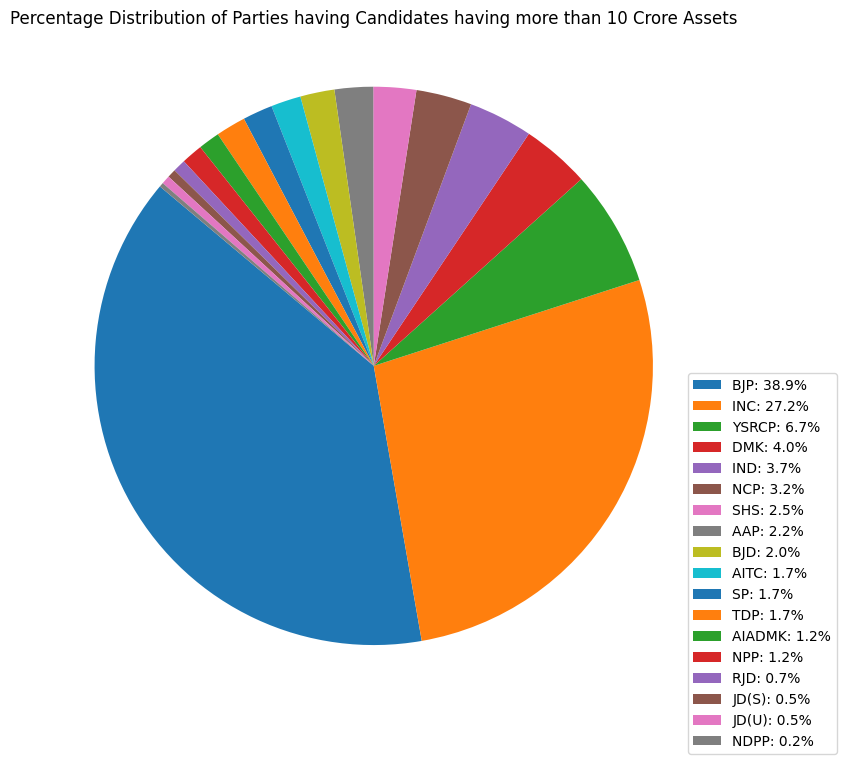

In [2357]:
filtered_df = train_given[train_given['Total Assets'] > 100000000]
total_candidates = filtered_df.shape[0]
party_counts = filtered_df['Party'].value_counts()
percentage_distribution = (party_counts / total_candidates) * 100

plt.figure(figsize=(8, 8))
patches, _ = plt.pie(percentage_distribution, startangle=140, pctdistance=0.85)
plt.title('Percentage Distribution of Parties having Candidates having more than 10 Crore Assets')
plt.axis('equal')
legend_labels = [f'{party}: {percentage:.1f}%' for party, percentage in zip(party_counts.index, percentage_distribution)]
plt.legend(legend_labels, loc="upper left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

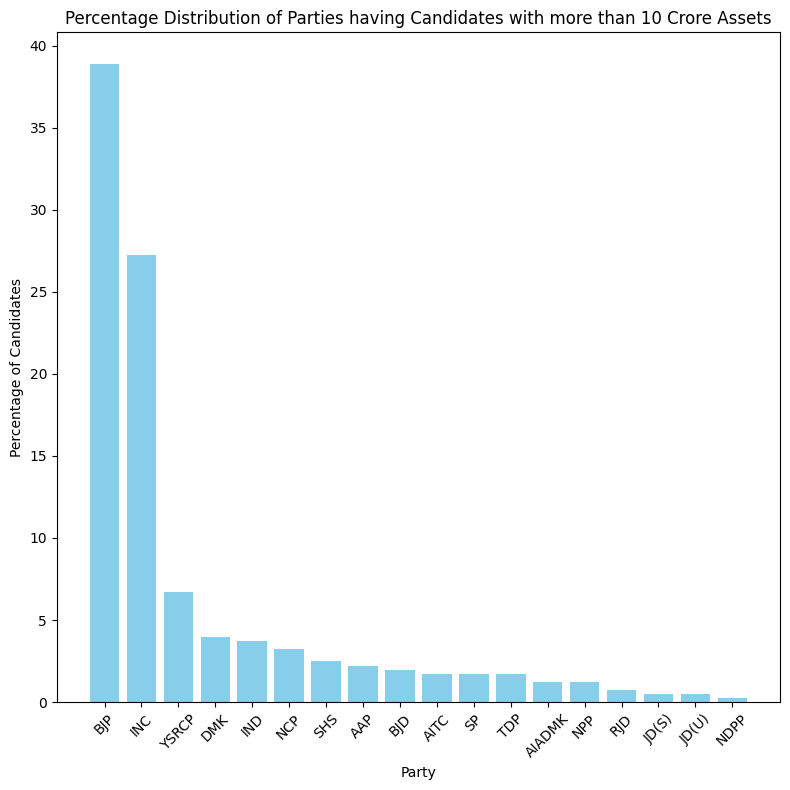

In [2358]:
filtered_df = train_given[train_given['Total Assets'] > 100000000]
total_candidates = filtered_df.shape[0]
party_counts = filtered_df['Party'].value_counts()
percentage_distribution = (party_counts / total_candidates) * 100

plt.figure(figsize=(8, 8))
plt.bar(percentage_distribution.index, percentage_distribution, color='skyblue')
plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage Distribution of Parties having Candidates with more than 10 Crore Assets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Data Preprocessing Part II - Preparation for Model Training

In [2359]:
train = pd.DataFrame()
train['Total Assets'] = list(train_given['Total Assets']) + list(deep['Total Assets'])
train['Liabilities'] = list(train_given['Liabilities']) + list(deep['Liabilities'])
train['SC'] = list(train_given['SC']) + list(deep['SC'])
train['ST'] = list(train_given['ST']) + list(deep['ST'])
train['Doctor'] = list(train_given['Doctor']) + list(deep['Doctor'])
train['Advocate'] = list(train_given['Advocate']) + list(deep['Advocate'])
train['Party'] = list(train_given['Party']) + list(deep['Party'])
train['Education'] = list(train_given['Education']) + list(deep['Education'])
train['Criminal Case'] = list(train_given['Criminal Case']) + list(deep['Criminal Case'])
train['state'] = list(train_given['state']) + list(deep['state'])

In [2360]:
encoder_party = LabelEncoder()
encoder_state = LabelEncoder()
encoder_Education = LabelEncoder()

scaler = StandardScaler()

train['Total Assets'] = scaler.fit_transform(train['Total Assets'].values.reshape(-1, 1))
train['Liabilities'] = scaler.fit_transform(train['Liabilities'].values.reshape(-1, 1))
train['Party'] = encoder_party.fit_transform(train['Party'])
train['state'] = encoder_state.fit_transform(train['state'])
train['Education'] = encoder_Education.fit_transform(train['Education'])

test['Total Assets'] = scaler.fit_transform(test['Total Assets'].values.reshape(-1, 1))
test['Liabilities'] = scaler.fit_transform(test['Liabilities'].values.reshape(-1, 1))
test['Party'] = encoder_party.fit_transform(test['Party'])
test['state'] = encoder_state.fit_transform(test['state'])

In [2361]:
X = train[[
    'SC', 'ST', 'Doctor', 'Advocate', 'Party', 'Criminal Case', 'Total Assets', 'Liabilities', 'state',
    ]]
Y = train['Education']

X_test = test[[
    'SC', 'ST', 'Doctor', 'Advocate', 'Party', 'Criminal Case', 'Total Assets', 'Liabilities', 'state',
    ]]

In [2362]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=0)

### Model Training and Evaluation

#### Random Forest Classifier

In [2363]:
for i in range(8, 66, 3):
    classifier_random_forest = RandomForestClassifier( n_estimators=i, max_depth=None, 
                                                  min_samples_split=18, random_state=2)
    classifier_random_forest.fit(X_train, Y_train)
    pred_random_forest = classifier_random_forest.predict(X_val)
    print("Random Forest Classifier with ", i, " estimators : ", f1_score(Y_val, pred_random_forest, average='weighted'))

for i in range(10, 20, 4):
    classifier_random_forest = RandomForestClassifier( n_estimators=53, max_depth=None,
                                                      min_samples_split=i, random_state=2)
    classifier_random_forest.fit(X_train, Y_train)
    pred_random_forest = classifier_random_forest.predict(X_val)
    print("Random Forest Classifier with ", i, " min_samples_split : ", f1_score(Y_val, pred_random_forest, average='weighted'))

Random Forest Classifier with  8  estimators :  0.2392761398401777
Random Forest Classifier with  11  estimators :  0.23389853324412146
Random Forest Classifier with  14  estimators :  0.24041431499004196
Random Forest Classifier with  17  estimators :  0.23119465578763598
Random Forest Classifier with  20  estimators :  0.23259421211569933
Random Forest Classifier with  23  estimators :  0.24094771256509964
Random Forest Classifier with  26  estimators :  0.24338709082146695
Random Forest Classifier with  29  estimators :  0.24015683739147078
Random Forest Classifier with  32  estimators :  0.23926719951494002
Random Forest Classifier with  35  estimators :  0.23570505205583625
Random Forest Classifier with  38  estimators :  0.24204076722322476
Random Forest Classifier with  41  estimators :  0.2458153163666282
Random Forest Classifier with  44  estimators :  0.24555473723616683
Random Forest Classifier with  47  estimators :  0.24416017016997096
Random Forest Classifier with  50  es

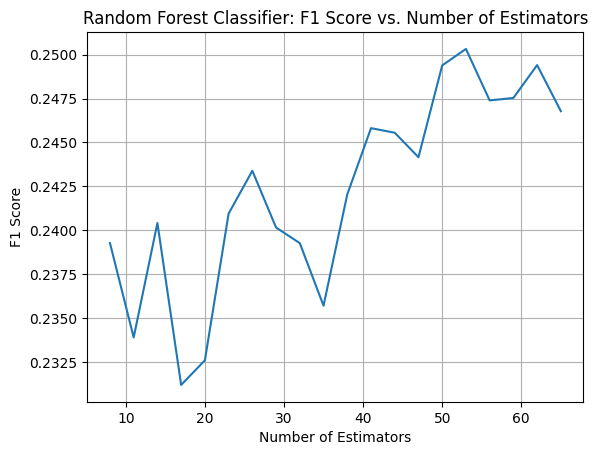

In [2364]:
numbers = [8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65]
f1_scores = [0.2392761398401777, 0.23389853324412146, 0.24041431499004196, 0.23119465578763598, 
              0.23259421211569933, 0.24094771256509964, 0.24338709082146695, 0.24015683739147078, 
              0.23926719951494002, 0.23570505205583625, 0.24204076722322476, 0.2458153163666282, 
              0.24555473723616683, 0.24416017016997096, 0.24938762141337895, 0.2503267676996916, 
              0.2473941904187417, 0.24753499656016642, 0.2494060509751146, 0.24678203416999656]
x = np.array(numbers)
y = np.array(f1_scores)
plt.plot(x, y)
plt.title('Random Forest Classifier: F1 Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

#### Linear Support Vector Classifier

In [2365]:
for i in range(-9, 3, 1):
    classifier_LinearSVC = LinearSVC(C=10**i, penalty='l2', loss='squared_hinge', dual=False, tol=0.0001,
                        random_state=0, max_iter=5000, verbose=0)
    classifier_LinearSVC.fit(X_train, Y_train)
    pred_LinearSVC = classifier_LinearSVC.predict(X_val)
    print("Linear SVC with C = ", 10**i, " : ", f1_score(Y_val, pred_LinearSVC, average='weighted'))

Linear SVC with C =  1e-09  :  0.07222695756463504
Linear SVC with C =  1e-08  :  0.07230497705377546
Linear SVC with C =  1e-07  :  0.07234424503525934
Linear SVC with C =  1e-06  :  0.11237719050822635
Linear SVC with C =  1e-05  :  0.16837116977759517
Linear SVC with C =  0.0001  :  0.18538314749152301
Linear SVC with C =  0.001  :  0.21751659065885406
Linear SVC with C =  0.01  :  0.2349797505246158
Linear SVC with C =  0.1  :  0.21998749594763267
Linear SVC with C =  1  :  0.2186536629332278
Linear SVC with C =  10  :  0.2169862360854055
Linear SVC with C =  100  :  0.2169862360854055


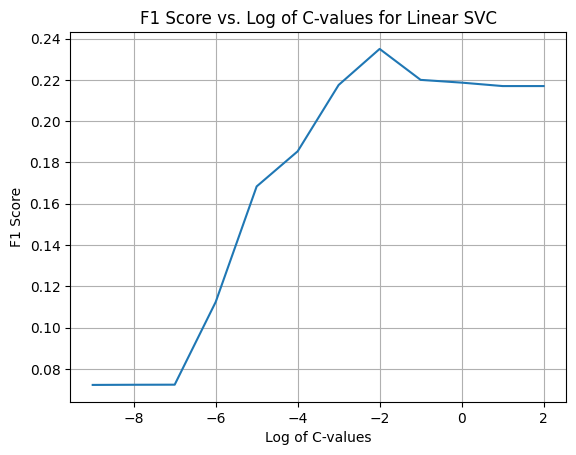

In [2366]:
x_values = [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2]
f1_scores = [0.07222695756463504, 0.07230497705377546, 0.07234424503525934, 0.11237719050822635,
             0.16837116977759517, 0.18538314749152301, 0.21751659065885406, 0.2349797505246158,
             0.21998749594763267, 0.2186536629332278, 0.2169862360854055, 0.2169862360854055]

# Plot
plt.plot(x_values, f1_scores)
plt.title('F1 Score vs. Log of C-values for Linear SVC')
plt.xlabel('Log of C-values')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

#### Logistic Regression

In [2367]:
classifier_LR = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
classifier_LR.fit(X_train, Y_train)
pred_LR = classifier_LR.predict(X_val)
print("Logistic Regression : ", f1_score(Y_val, pred_LR, average='weighted'))

Logistic Regression :  0.21735976212992825


#### K-Nearest Neighbors

In [2368]:
for i in range(8, 60, 2):
    classifier_KNN = KNeighborsClassifier(n_neighbors=i, p=4 , metric='minkowski')
    classifier_KNN.fit(X_train, Y_train)
    pred_KNN = classifier_KNN.predict(X_val)
    print("KNN Classifier with ", i, " neighbors : ", f1_score(Y_val, pred_KNN, average='weighted'))

KNN Classifier with  8  neighbors :  0.22229588015550286
KNN Classifier with  10  neighbors :  0.23474847616241193
KNN Classifier with  12  neighbors :  0.23027904464911506
KNN Classifier with  14  neighbors :  0.23455728606128737
KNN Classifier with  16  neighbors :  0.2225110550713853
KNN Classifier with  18  neighbors :  0.23550315658459317
KNN Classifier with  20  neighbors :  0.234662308137492
KNN Classifier with  22  neighbors :  0.2407657908928132
KNN Classifier with  24  neighbors :  0.2321496875823231
KNN Classifier with  26  neighbors :  0.2434139085397893
KNN Classifier with  28  neighbors :  0.24402564401606905
KNN Classifier with  30  neighbors :  0.2435327389408905
KNN Classifier with  32  neighbors :  0.2362625770632905
KNN Classifier with  34  neighbors :  0.22783226266981862
KNN Classifier with  36  neighbors :  0.22563057067484432
KNN Classifier with  38  neighbors :  0.22525261683407236
KNN Classifier with  40  neighbors :  0.23084737372756461
KNN Classifier with  42

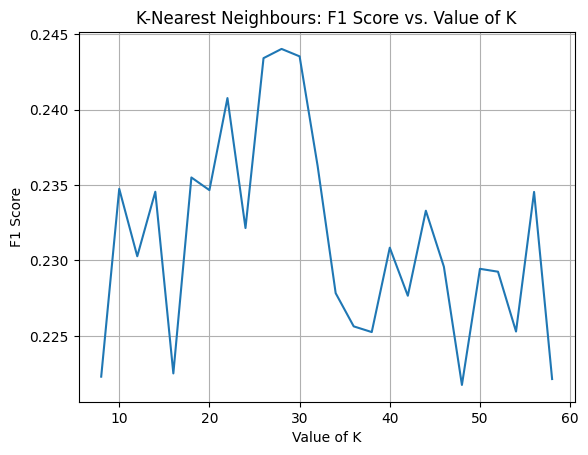

In [2369]:
x_values = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
f1_scores = [0.22229588015550286, 0.23474847616241193, 0.23027904464911506, 0.23455728606128737, 0.2225110550713853,
             0.23550315658459317, 0.234662308137492, 0.2407657908928132, 0.2321496875823231, 0.2434139085397893,
             0.24402564401606905, 0.2435327389408905, 0.2362625770632905, 0.22783226266981862, 0.22563057067484432,
             0.22525261683407236, 0.23084737372756461, 0.227661100678285, 0.23329818395411514, 0.2295844964256147,
             0.22174829188747042, 0.22944630177409794, 0.22925481676771364, 0.22528856070035908, 0.23454558698995306,
             0.22213777512656416]

plt.plot(x_values, f1_scores)
plt.title('K-Nearest Neighbours: F1 Score vs. Value of K')
plt.xlabel('Value of K')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

#### Bernoulli Naive Bayes

In [2370]:
for i in range(-7, 4, 1):
    classifier_BNB = BernoulliNB(alpha=10**i)
    classifier_BNB.fit(X_train, Y_train)
    pred_BNB = classifier_BNB.predict(X_val)
    print("Bernoulli Naive Bayes with alpha = ", 10**i, " : ", f1_score(Y_val, pred_BNB, average='weighted'))


Bernoulli Naive Bayes with alpha =  1e-07  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  1e-06  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  1e-05  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  0.0001  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  0.001  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  0.01  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  0.1  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  1  :  0.1938240375029162
Bernoulli Naive Bayes with alpha =  10  :  0.19366234866925336
Bernoulli Naive Bayes with alpha =  100  :  0.19361156382439984
Bernoulli Naive Bayes with alpha =  1000  :  0.16380210385434793


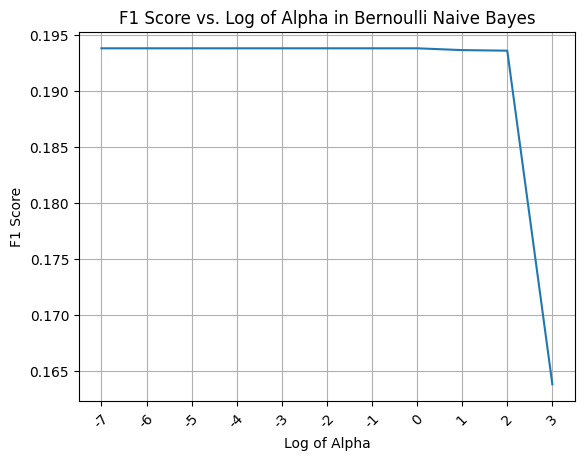

In [2371]:
alphas = ['-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3']
f1_scores = [0.1938240375029162, 0.1938240375029162, 0.1938240375029162, 0.1938240375029162, 0.1938240375029162,
             0.1938240375029162, 0.1938240375029162, 0.1938240375029162, 0.19366234866925336, 0.19361156382439984,
             0.16380210385434793]

plt.plot(alphas, f1_scores)
plt.title('F1 Score vs. Log of Alpha in Bernoulli Naive Bayes')
plt.xlabel('Log of Alpha')
plt.ylabel('F1 Score')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Final Evaluation

In [2372]:
print("f1-Scores")

classifier_random_forest = RandomForestClassifier( n_estimators=53, max_depth=None, 
                                                  min_samples_split=18, random_state=2)
classifier_random_forest.fit(X_train, Y_train)
pred_random_forest = classifier_random_forest.predict(X_val)
print("Random Forest Classifier : ", f1_score(Y_val, pred_random_forest, average='weighted'))

classifier_LinearSVC = LinearSVC(C=0.01, penalty='l2', loss='squared_hinge', dual=False, tol=0.0001,
                        random_state=0, max_iter=5000, verbose=0)
classifier_LinearSVC.fit(X_train, Y_train)
pred_LinearSVC = classifier_LinearSVC.predict(X_val)
print("Linear SVC               : ", f1_score(Y_val, pred_LinearSVC, average='weighted'))

classifier_LR = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=5000)
classifier_LR.fit(X_train, Y_train)
pred_LR = classifier_LR.predict(X_val)
print("Logistic Regression      : ", f1_score(Y_val, pred_LR, average='weighted'))

classifier_KNN = KNeighborsClassifier(n_neighbors=28, p=4 , metric='minkowski')
classifier_KNN.fit(X_train, Y_train)
pred_KNN = classifier_KNN.predict(X_val)
print("K Nearest Neighbours     : ", f1_score(Y_val, pred_KNN, average='weighted'))

classifier_BNB = BernoulliNB(alpha=0.1)
classifier_BNB.fit(X_train, Y_train)
pred_BNB = classifier_BNB.predict(X_val)
print("Bernoulli Naive Bayes    : ", f1_score(Y_val, pred_BNB, average='weighted'))


f1-Scores
Random Forest Classifier :  0.2503267676996916
Linear SVC               :  0.2349797505246158
Logistic Regression      :  0.21735976212992825
K Nearest Neighbours     :  0.24402564401606905
Bernoulli Naive Bayes    :  0.1938240375029162


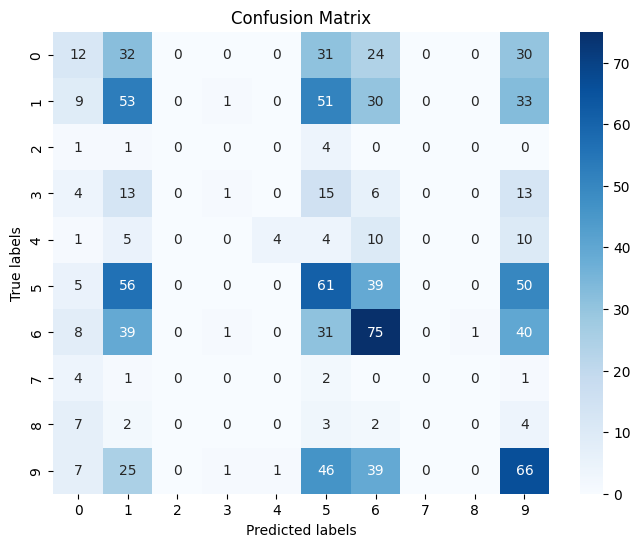

In [2373]:
classifier_random_forest = RandomForestClassifier( n_estimators=53, max_depth=None, 
                                                  min_samples_split=18, random_state=2)
classifier_random_forest.fit(X_train, Y_train)
pred_random_forest = classifier_random_forest.predict(X_val)
pred_train = classifier_random_forest.predict(X_train)

conf_matrix = confusion_matrix(Y_val, pred_random_forest)
conf_matrix_2 = confusion_matrix(Y_train, pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

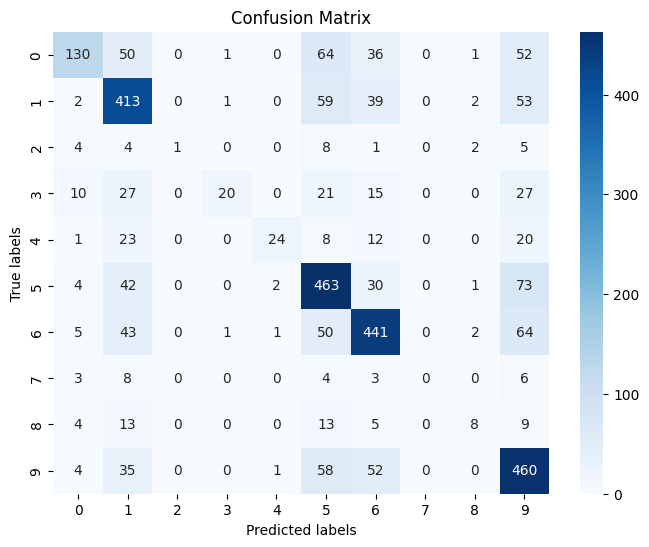

In [2374]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Predicting the Education Level for Test Data (For Submission)

In [2375]:
classifier_random_forest = RandomForestClassifier( n_estimators=53, max_depth=None, 
                                                  min_samples_split=18, random_state=2 )
classifier_random_forest.fit(X_train, Y_train)
Y_test = classifier_random_forest.predict(X_test)
submission = pd.DataFrame({'ID': test['ID'], 'Education': encoder_Education.inverse_transform(Y_test)})
submission.to_csv('prediction.csv', index=False)